#  Multiclass Logistic Regression on the Iris Dataset


## 1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd


## a) Load the Iris Dataset

In [2]:
iris = load_iris()
X = iris.data    # (150, 4)
y = iris.target  # (150,)

print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique classes:", np.unique(y))

Features shape: (150, 4)
Labels shape: (150,)
Unique classes: [0 1 2]


## b) Preprocess the Data

In [3]:
# Split the dataset (60% training, 40% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

def normalize(X):
    """Min-Max Normalization to [0,1]"""
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

def standardize(X):
    """Z-score Standardization"""
    return (X - X.mean(axis=0)) / X.std(axis=0)

# Preprocess data
X_train_norm = normalize(X_train)
X_test_norm  = normalize(X_test)

X_train_std = standardize(X_train)
X_test_std  = standardize(X_test)

## c) Implement Softmx Functions


In [4]:
def softmax(z):
    """
    Compute the softmax of each row of the input z.
    """
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def one_hot_encode(y, num_classes):
    """
    Convert label vector y to one-hot encoded matrix.
    """
    m = y.shape[0]
    y_encoded = np.zeros((m, num_classes))
    y_encoded[np.arange(m), y] = 1
    return y_encoded

def compute_loss(y_true, y_pred):
    """
    Compute the categorical cross-entropy loss.
    """
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-15)) / m
    return loss

## d) Implement the Multiclass Logistic Regression Model
# 
 We create a class `LogisticRegressionMulti` that implements:
# 
- **Batch Gradient Descent (GD):** The weight update is performed using all samples.
- **Stochastic Gradient Descent (SGD):** The weight update is performed on one sample at a time.
# 
Both methods track the training loss at every epoch.

In [5]:
class LogisticRegressionMulti:
    def __init__(self, learning_rate=0.01, epochs=1000, verbose=False):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.verbose = verbose
    
    def fit_gd(self, X, y):
        """
        Train using Batch Gradient Descent.
        """
        m, n = X.shape
        num_classes = len(np.unique(y))
        self.W = np.zeros((n, num_classes))
        y_encoded = one_hot_encode(y, num_classes)
        self.loss_history = []
        
        for epoch in range(self.epochs):
            logits = np.dot(X, self.W)
            probs = softmax(logits)
            loss = compute_loss(y_encoded, probs)
            self.loss_history.append(loss)
            
            # Gradient calculation
            grad = np.dot(X.T, (probs - y_encoded)) / m
            self.W -= self.learning_rate * grad
            
            if self.verbose and epoch % 100 == 0:
                print(f"[GD] Epoch {epoch}/{self.epochs} - Loss: {loss:.4f}")
        return self
    
    def fit_sgd(self, X, y):
        """
        Train using Stochastic Gradient Descent.
        """
        m, n = X.shape
        num_classes = len(np.unique(y))
        self.W = np.zeros((n, num_classes))
        y_encoded = one_hot_encode(y, num_classes)
        self.loss_history = []
        
        for epoch in range(self.epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            for i in indices:
                xi = X[i:i+1]  # shape (1, n)
                yi = y_encoded[i:i+1]  # shape (1, num_classes)
                logits = np.dot(xi, self.W)
                probs = softmax(logits)
                grad = np.dot(xi.T, (probs - yi))
                self.W -= self.learning_rate * grad
            # Compute loss at the end of epoch
            logits = np.dot(X, self.W)
            probs = softmax(logits)
            loss = compute_loss(y_encoded, probs)
            self.loss_history.append(loss)
            
            if self.verbose and epoch % 100 == 0:
                print(f"[SGD] Epoch {epoch}/{self.epochs} - Loss: {loss:.4f}")
        return self
    
    def predict(self, X):
        logits = np.dot(X, self.W)
        probs = softmax(logits)
        return np.argmax(probs, axis=1)

 3,4,5) Train and Evaluate the Model
# We now run experiments using both GD and SGD.

Training with Batch Gradient Descent (GD) on Normalized Data

In [6]:
# Train using Batch Gradient Descent on normalized data
model_gd = LogisticRegressionMulti(learning_rate=0.1, epochs=1000, verbose=True)
model_gd.fit_gd(X_train_norm, y_train)

# Make predictions and evaluate
y_pred_gd = model_gd.predict(X_test_norm)
accuracy_gd = accuracy_score(y_test, y_pred_gd)
print("\n[GD] Test Accuracy: {:.2f}%".format(accuracy_gd * 100))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gd))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gd))

[GD] Epoch 0/1000 - Loss: 1.0986
[GD] Epoch 100/1000 - Loss: 0.8133
[GD] Epoch 200/1000 - Loss: 0.7026
[GD] Epoch 300/1000 - Loss: 0.6401
[GD] Epoch 400/1000 - Loss: 0.6008
[GD] Epoch 500/1000 - Loss: 0.5739
[GD] Epoch 600/1000 - Loss: 0.5543
[GD] Epoch 700/1000 - Loss: 0.5393
[GD] Epoch 800/1000 - Loss: 0.5274
[GD] Epoch 900/1000 - Loss: 0.5177

[GD] Test Accuracy: 66.67%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.00      0.00      0.00        20
           2       0.50      1.00      0.67        20

    accuracy                           0.67        60
   macro avg       0.50      0.67      0.56        60
weighted avg       0.50      0.67      0.56        60

Confusion Matrix:
 [[20  0  0]
 [ 0  0 20]
 [ 0  0 20]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

 Visualize the Loss Curve for GD

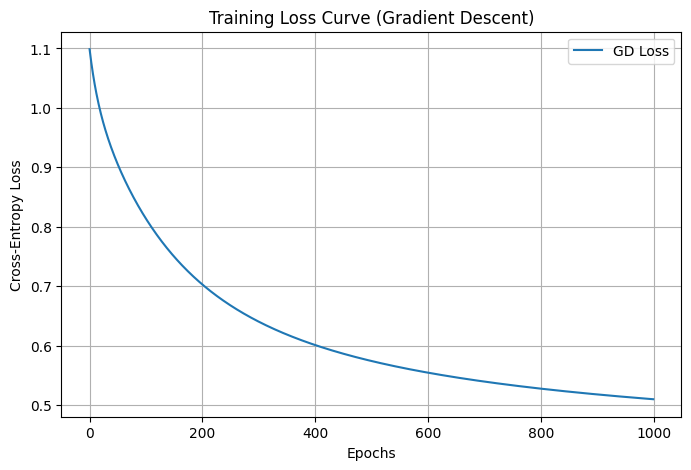

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(model_gd.loss_history, label="GD Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss Curve (Gradient Descent)")
plt.legend()
plt.grid(True)
plt.show()

 ### Training with Stochastic Gradient Descent (SGD) on Normalized Data

In [8]:
# Train using Stochastic Gradient Descent on normalized data
model_sgd = LogisticRegressionMulti(learning_rate=0.01, epochs=1000, verbose=True)
model_sgd.fit_sgd(X_train_norm, y_train)

# Make predictions and evaluate
y_pred_sgd = model_sgd.predict(X_test_norm)
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
print("\n[SGD] Test Accuracy: {:.2f}%".format(accuracy_sgd * 100))
print("\nClassification Report:\n", classification_report(y_test, y_pred_sgd))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_sgd))

[SGD] Epoch 0/1000 - Loss: 1.0397
[SGD] Epoch 100/1000 - Loss: 0.5169
[SGD] Epoch 200/1000 - Loss: 0.4722
[SGD] Epoch 300/1000 - Loss: 0.4527
[SGD] Epoch 400/1000 - Loss: 0.4408
[SGD] Epoch 500/1000 - Loss: 0.4323
[SGD] Epoch 600/1000 - Loss: 0.4258
[SGD] Epoch 700/1000 - Loss: 0.4205
[SGD] Epoch 800/1000 - Loss: 0.4161
[SGD] Epoch 900/1000 - Loss: 0.4123

[SGD] Test Accuracy: 78.33%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.71      0.60      0.65        20
           2       0.65      0.75      0.70        20

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60

Confusion Matrix:
 [[20  0  0]
 [ 0 12  8]
 [ 0  5 15]]


 Visualize the Loss Curve for SGD

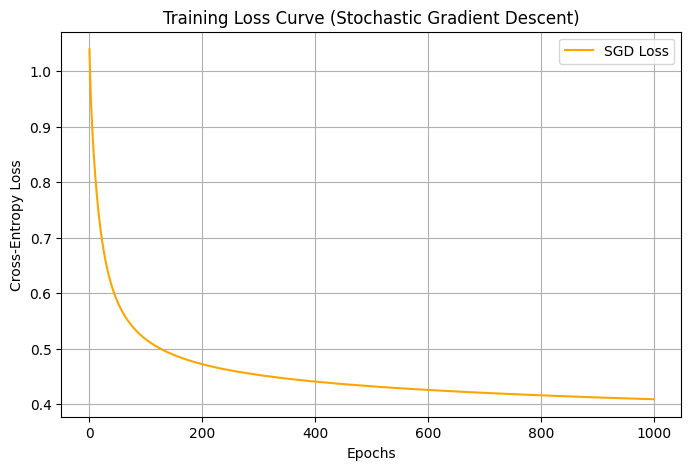

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(model_sgd.loss_history, label="SGD Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss Curve (Stochastic Gradient Descent)")
plt.legend()
plt.grid(True)
plt.show()